# Recommendation System Notebook

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import random

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from imblearn.over_sampling import SMOTE,RandomOverSampler
from textblob import TextBlob
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
import joblib

# Filtering out the warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth=1000

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Sentiment Analysis

In [2]:
# Reading data file from GitHub. # MovieLens
df = pd.read_csv('https://raw.githubusercontent.com/GangamRitesh/Capstone/main/sample30.csv')

In [3]:
# Checking the shape of data frame
df.shape

(30000, 15)

In [4]:
# Checking the columns 
df.columns.values

array(['id', 'brand', 'categories', 'manufacturer', 'name',
       'reviews_date', 'reviews_didPurchase', 'reviews_doRecommend',
       'reviews_rating', 'reviews_text', 'reviews_title',
       'reviews_userCity', 'reviews_userProvince', 'reviews_username',
       'user_sentiment'], dtype=object)

In [5]:
# Checking columns decription 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [6]:
# Checking the distribution of numeric columns
df.describe()

,reviews_rating
count,30000.000000
mean,4.483133
std,0.988441
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
# Checking top 2 rows of data frame
df.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive


### Exploratory data analysis

#### Data Visualization

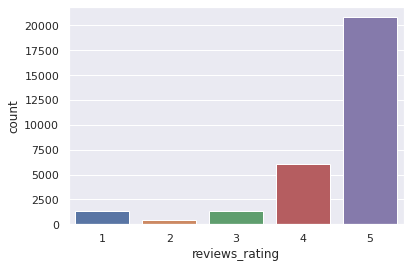

In [8]:
# Checking the rating distribution
sns.set_theme(style="darkgrid")
sns.countplot(df.reviews_rating)
plt.show()

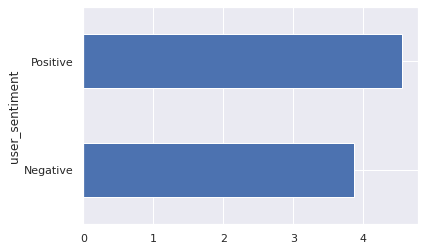

In [9]:
# Checking the average ratings for positive and negative reviews
df.groupby(['user_sentiment'])['reviews_rating'].mean().plot.barh()
plt.show()

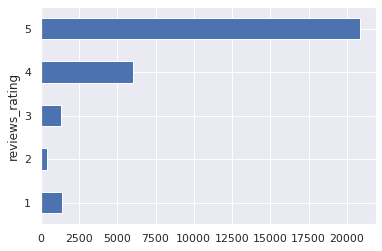

In [10]:
# Checking the count of  for positive and negative sentiment for each rating
df.groupby(['reviews_rating'])['user_sentiment'].count().plot.barh()
plt.show()

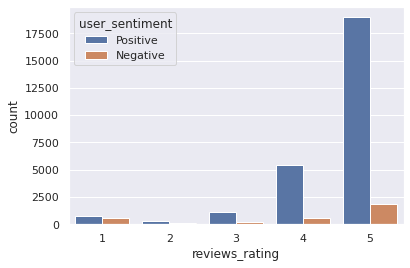

In [11]:
# checking the usersentiment for each rating
sns.countplot(df.reviews_rating, hue = df.user_sentiment)
plt.show()

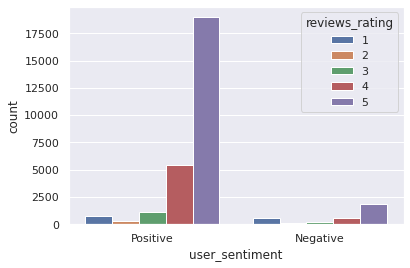

In [12]:
# checking the user rating distribution for each positive and negative sentiment
sns.countplot(df.user_sentiment, hue = df.reviews_rating)
plt.show()

## Data Cleaning
### Missing value treatment

In [13]:
# Storing the missing data and missing data percentage in the missing_data dataframe
def missing_values(df):
    missing_data  = pd.DataFrame(columns=['Column'
                                          ,'Type'
                                          ,'Missing_count'
                                          ,'Missing_percentage'])
    for i in df.columns:
        null_count = df[i].isna().sum()
        null_perc  = null_count/len(df)*100
        if null_count != 0:
            df2={'Column':i
            ,'Type': df[i].dtype
            ,'Missing_count': null_count
            ,'Missing_percentage' : null_perc
            }
            missing_data = missing_data.append(df2,ignore_index=True)
    return missing_data.sort_values(by = 'Missing_percentage',ascending= False)

In [14]:
#checking the missing values in the data frame
missing_data = missing_values(df)
missing_data

,Column,Type,Missing_count,Missing_percentage
6,reviews_userProvince,object,29830,99.433333
5,reviews_userCity,object,28071,93.570000
2,reviews_didPurchase,object,14068,46.893333
3,reviews_doRecommend,object,2570,8.566667
4,reviews_title,object,190,0.633333
0,manufacturer,object,141,0.470000
7,reviews_username,object,63,0.210000
1,reviews_date,object,46,0.153333
8,user_sentiment,object,1,0.003333


#### Handling Missing values

In [15]:
# Dropping columns whith high Null value percentage
df.drop(columns = ['reviews_userProvince','reviews_userCity','reviews_didPurchase'],axis =1,inplace = True)
df.shape

(30000, 12)

In [16]:
# Dropping the column reviews_date as the column can't be used for analysis
df.drop(columns = ['reviews_date'],axis =1,inplace = True)
df.shape

(30000, 11)

In [17]:
df = df[~df.user_sentiment.isna()]
df.shape

(29999, 11)

In [18]:
missing_data = missing_values(df)
missing_data

,Column,Type,Missing_count,Missing_percentage
1,reviews_doRecommend,object,2570,8.566952
2,reviews_title,object,190,0.633354
0,manufacturer,object,141,0.470016
3,reviews_username,object,63,0.210007


In [19]:
# Creating a dataframe with columns requied from analysing the sentiment of the reviews
df_sent = df[['user_sentiment']]
# df_sent['reviews'] = df['brand'] +' '+ df['categories'] +' '+df['reviews_title']+' '+ df['reviews_text'] 
df_sent['reviews'] = df['reviews_title']+' '+ df['reviews_text'] 
df_sent.head()

,user_sentiment,reviews
0,Positive,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,Positive,Good Good flavor. This review was collected as part of a promotion.
2,Positive,Good Good flavor.
3,Negative,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess."
4,Negative,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.


In [20]:
# Converting the type of reviews column to String type
df_sent['reviews'] = df_sent['reviews'].astype('str')

In [21]:
# Mapping the user_sentiment column to numeric values (0 if negative and 1 if positive)
df_sent.user_sentiment = df_sent.user_sentiment.apply(lambda x: 0 if x == 'Negative' else 1)

In [22]:
# Checking the dataframe
df_sent.head()

,user_sentiment,reviews
0,1,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,1,Good Good flavor. This review was collected as part of a promotion.
2,1,Good Good flavor.
3,0,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess."
4,0,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.


## Text processing

#### Convert text to lowercase

In [23]:
df_sent.reviews = df_sent.reviews.str.lower()
df_sent[['reviews']].head()

,reviews
0,just awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. so hype! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,good good flavor. this review was collected as part of a promotion.
2,good good flavor.
3,"disappointed i read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews i had read. for starters, neither my boyfriend nor i could notice any sort of enhanced or 'captivating' sensation. what we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. it was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. i'm disappointed that i paid as much as i did for a lube that i won't use again, when i could just use their normal personal lubricant for 1) less money and 2) less mess."
4,irritation my husband bought this gel for us. the gel caused irritation and it felt like it was burning my skin. i wouldn't recommend this gel.


#### Remove numbers


In [24]:
# Function to remove digits.
def remove_numbers(text): 
  text_processed = re.sub(r'\d+', '', text)
  return text_processed

In [25]:
df_sent.reviews = df_sent.reviews.apply(lambda text: remove_numbers(text))
df_sent[['reviews']].head()

,reviews
0,just awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. so hype! i listen to this everyday at the gym! i give it star rating all the way. her metaphors are just crazy.
1,good good flavor. this review was collected as part of a promotion.
2,good good flavor.
3,"disappointed i read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews i had read. for starters, neither my boyfriend nor i could notice any sort of enhanced or 'captivating' sensation. what we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. it was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. i'm disappointed that i paid as much as i did for a lube that i won't use again, when i could just use their normal personal lubricant for ) less money and ) less mess."
4,irritation my husband bought this gel for us. the gel caused irritation and it felt like it was burning my skin. i wouldn't recommend this gel.


#### Remove punctuations

In [26]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [27]:
def remove_punctuation(text): 
  text_processed = "".join([char for char in text if char not in string.punctuation])
  return text_processed

In [28]:
df_sent.reviews = df_sent.reviews.apply(lambda text: remove_punctuation(text))
df_sent[['reviews']].head()

,reviews
0,just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it star rating all the way her metaphors are just crazy
1,good good flavor this review was collected as part of a promotion
2,good good flavor
3,disappointed i read through the reviews on here before looking in to buying one of the couples lubricants and was ultimately disappointed that it didnt even live up to the reviews i had read for starters neither my boyfriend nor i could notice any sort of enhanced or captivating sensation what we did notice however was the messy consistency that was reminiscent of a more liquidy vaseline it was difficult to clean up and was not a pleasant especially since it lacked the captivating sensation we had both been expecting im disappointed that i paid as much as i did for a lube that i wont use again when i could just use their normal personal lubricant for less money and less mess
4,irritation my husband bought this gel for us the gel caused irritation and it felt like it was burning my skin i wouldnt recommend this gel


#### Remove stopwords

In [29]:
stop_words = stopwords.words('english')
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [30]:
def remove_stopwords(text):

    # tokenize into words
    words = word_tokenize(text)

    # remove stop words
    words = [word for word in words if word not in stop_words]

    # join words to make sentence
    text_processed = " ".join(words)
    
    return text_processed

In [31]:
df_sent.reviews = df_sent.reviews.apply(lambda text: remove_stopwords(text))
df_sent[['reviews']].head()

,reviews
0,awesome love album good hip hop side current pop sound hype listen everyday gym give star rating way metaphors crazy
1,good good flavor review collected part promotion
2,good good flavor
3,disappointed read reviews looking buying one couples lubricants ultimately disappointed didnt even live reviews read starters neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant less money less mess
4,irritation husband bought gel us gel caused irritation felt like burning skin wouldnt recommend gel


#### Remove rare words

In [32]:
# Storing all the words and count in a set
word_count = {}
def get_vocab(df):
  vocab = set()
  reviews = df.reviews
  for review in reviews:
    for token in review.split(' '):
      vocab.add(token)
  return len(vocab)
def get_word_count(df):
  reviews = df.reviews
  for review in reviews:
    for token in review.split(' '):
      word_count[token] = word_count.get(token, 0) + 1
  return len(word_count)


In [33]:
# Remove rarewords function
def remove_rare_words(text):

    # tokenize into words
    words = word_tokenize(text)

    # remove rare words (count < 30 )
    words = [word for word in words if word_count.get(word) > 20]

    # join words to make sentence
    text_processed = " ".join(words)
    
    return text_processed

In [34]:
print(get_vocab(df_sent))
print(get_word_count(df_sent))
df_sent.reviews = df_sent.reviews.apply(lambda text: remove_rare_words(text))
print(get_vocab(df_sent))

21427
21427
2496


In [35]:
df_sent[['reviews']].head()

,reviews
0,awesome love album good side current pop sound listen everyday gym give star rating way crazy
1,good good flavor review collected part promotion
2,good good flavor
3,disappointed read reviews looking buying one disappointed didnt even live reviews read boyfriend could notice sort notice however messy consistency vaseline difficult clean pleasant especially since expecting im disappointed paid much wont use could use normal personal less money less mess
4,husband bought gel us gel caused felt like burning skin wouldnt recommend gel


#### Remove frequent words

In [36]:
# Removing all the words in revies which occured more than 10000 times
def remove_frequent_words(text):

    # tokenize into words
    words = word_tokenize(text)

    # remove rare words
    words = [word for word in words if word_count[word] < 10000]

    # join words to make sentence
    text_processed = " ".join(words)
    
    return text_processed

In [37]:
print(get_vocab(df_sent))
print(get_word_count(df_sent))
df_sent.reviews = df_sent.reviews.apply(lambda text: remove_rare_words(text))
print(get_vocab(df_sent))

2496
21427
2496


In [38]:
df_sent[['reviews']].head()

,reviews
0,awesome love album good side current pop sound listen everyday gym give star rating way crazy
1,good good flavor review collected part promotion
2,good good flavor
3,disappointed read reviews looking buying one disappointed didnt even live reviews read boyfriend could notice sort notice however messy consistency vaseline difficult clean pleasant especially since expecting im disappointed paid much wont use could use normal personal less money less mess
4,husband bought gel us gel caused felt like burning skin wouldnt recommend gel


#### Stemming

In [39]:
stemmer= PorterStemmer()

def stemmer_func(text):
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]

    # stems = [str(TextBlob(stemmer.stem(word)).correct()) for word in word_tokens]
    text_processed = " ".join(stems)
    return text_processed


In [40]:
df_sent.reviews = df_sent.reviews.apply(lambda text: stemmer_func(text))
df_sent.head(5)

,user_sentiment,reviews
0,1,awesom love album good side current pop sound listen everyday gym give star rate way crazi
1,1,good good flavor review collect part promot
2,1,good good flavor
3,0,disappoint read review look buy one disappoint didnt even live review read boyfriend could notic sort notic howev messi consist vaselin difficult clean pleasant especi sinc expect im disappoint paid much wont use could use normal person less money less mess
4,0,husband bought gel us gel caus felt like burn skin wouldnt recommend gel


## Creating Bag Of Words model using count vectorizer function

In [41]:
reviews =  [review for review in df_sent.reviews]
vectorizer = CountVectorizer()
bow_model = vectorizer.fit_transform(reviews)
print(bow_model) 
 # returns the rown and column number of cells which have 1 as value

  (0, 101)	1
  (0, 931)	1
  (0, 34)	1
  (0, 689)	1
  (0, 1422)	1
  (0, 386)	1
  (0, 1179)	1
  (0, 1472)	1
  (0, 912)	1
  (0, 531)	1
  (0, 723)	1
  (0, 673)	1
  (0, 1501)	1
  (0, 1251)	1
  (0, 1755)	1
  (0, 373)	1
  (1, 689)	2
  (1, 608)	1
  (1, 1308)	1
  (1, 303)	1
  (1, 1125)	1
  (1, 1215)	1
  (2, 689)	2
  (2, 608)	1
  (3, 1308)	2
  :	:
  (29997, 817)	1
  (29998, 673)	1
  (29998, 1755)	1
  (29998, 1308)	1
  (29998, 303)	1
  (29998, 1125)	1
  (29998, 1215)	1
  (29998, 1211)	2
  (29998, 551)	1
  (29998, 1352)	1
  (29998, 1264)	2
  (29998, 106)	1
  (29998, 759)	1
  (29998, 1270)	1
  (29998, 190)	1
  (29998, 953)	1
  (29998, 898)	1
  (29998, 333)	1
  (29998, 748)	1
  (29998, 747)	1
  (29998, 738)	1
  (29998, 724)	3
  (29998, 817)	1
  (29998, 1528)	1
  (29998, 328)	1


In [42]:
print(vectorizer.get_feature_names())

['abil', 'abl', 'absolut', 'absorb', 'access', 'accid', 'acn', 'across', 'act', 'action', 'activ', 'actor', 'actual', 'ad', 'adam', 'adapt', 'add', 'addict', 'addit', 'admit', 'ador', 'adult', 'adventur', 'advertis', 'afford', 'afraid', 'afternoon', 'afterward', 'age', 'agedefi', 'ago', 'agre', 'ahead', 'air', 'album', 'alcohol', 'aldean', 'ale', 'alex', 'alic', 'allerg', 'allergi', 'allow', 'almost', 'alon', 'along', 'alot', 'alreadi', 'alright', 'also', 'altern', 'although', 'alway', 'amaz', 'amazingli', 'amazon', 'american', 'amount', 'andor', 'anim', 'anna', 'annoy', 'anoth', 'answer', 'anymor', 'anyon', 'anyth', 'anytim', 'anyway', 'anywher', 'apart', 'appear', 'appli', 'applianc', 'applic', 'appreci', 'area', 'arent', 'arm', 'aroma', 'around', 'arriv', 'art', 'artist', 'ask', 'asleep', 'assembl', 'attach', 'attempt', 'attent', 'attract', 'aubrey', 'audio', 'aussi', 'avail', 'aveeno', 'averag', 'averi', 'avoid', 'aw', 'away', 'awesom', 'awhil', 'awsom', 'axe', 'babi', 'back', 'bac

In [43]:
bow_model.shape

(29999, 1836)

In [44]:
bow_model_df = pd.DataFrame(bow_model.toarray(), columns = vectorizer.get_feature_names())

In [45]:
bow_model_df.head()

,abil,abl,absolut,absorb,access,accid,acn,across,act,action,activ,actor,actual,ad,adam,adapt,add,addict,addit,admit,ador,adult,adventur,advertis,afford,afraid,afternoon,afterward,age,agedefi,ago,agre,ahead,air,album,alcohol,aldean,ale,alex,alic,...,without,woman,women,wonder,wont,wood,word,wore,work,workout,world,worn,worri,wors,worst,worth,worthi,would,wouldnt,wouldv,wow,wrinkl,write,written,wrong,ye,year,yellow,yet,yogurt,youll,young,younger,your,youv,yr,yum,yummi,zac,zombi
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Creating TF-IDF model using TfidfVectorizer function

In [46]:
tv = TfidfVectorizer()
v = tv.fit_transform(reviews)
tfidf_df = pd.DataFrame(v.toarray(), columns = tv.get_feature_names())

In [47]:
tfidf_df.shape

(29999, 1836)

In [48]:
joblib.dump(tv, 'tfidf_vectorizer.pkl') 

['tfidf_vectorizer.pkl']

In [49]:
tfidf_df.tail()

,abil,abl,absolut,absorb,access,accid,acn,across,act,action,activ,actor,actual,ad,adam,adapt,add,addict,addit,admit,ador,adult,adventur,advertis,afford,afraid,afternoon,afterward,age,agedefi,ago,agre,ahead,air,album,alcohol,aldean,ale,alex,alic,...,without,woman,women,wonder,wont,wood,word,wore,work,workout,world,worn,worri,wors,worst,worth,worthi,would,wouldnt,wouldv,wow,wrinkl,write,written,wrong,ye,year,yellow,yet,yogurt,youll,young,younger,your,youv,yr,yum,yummi,zac,zombi
29994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Building

### Splitting data into train and test

In [50]:
# Splitting the data into trrain and test datasets BOW model data
X_train_bw,X_test_bw, y_train_bw, y_test_bw = train_test_split(bow_model,df_sent.user_sentiment, train_size=0.8, stratify = df_sent.user_sentiment, random_state=100 )

# Splitting the data into trrain and test datasets TF-IDF model data
X_train_tf,X_test_tf, y_train_tf, y_test_tf = train_test_split(tfidf_df,df_sent.user_sentiment, train_size=0.8, stratify = df_sent.user_sentiment, random_state=100 )

## Handling Class Imbalance

In [51]:
y_train_bw.value_counts(normalize = True)*100

1    88.774532
0    11.225468
Name: user_sentiment, dtype: float64

In [52]:
y_train_tf.value_counts(normalize = True)*100

1    88.774532
0    11.225468
Name: user_sentiment, dtype: float64

Handling imbalance using SMOTE technique

In [53]:
sm1= SMOTE()
sm2= SMOTE()
x_train_bw_sm,y_train_bw_sm = sm1.fit_resample(X_train_bw,y_train_bw)
x_train_tf_sm,y_train_tf_sm = sm2.fit_resample(X_train_tf,y_train_tf)

In [54]:
print('Bag of Words model (before smote) : ',Counter(y_train_bw))
print('Bag of Words model (after smote)  : ',Counter(y_train_bw_sm))
print('TF-IDF model (before smote)       : ',Counter(y_train_tf))
print('TF-IDF model (after smote)        : ',Counter(y_train_tf_sm))

Bag of Words model (before smote) :  Counter({1: 21305, 0: 2694})
Bag of Words model (after smote)  :  Counter({1: 21305, 0: 21305})
TF-IDF model (before smote)       :  Counter({1: 21305, 0: 2694})
TF-IDF model (after smote)        :  Counter({1: 21305, 0: 21305})


In [55]:
ros1= RandomOverSampler()
ros2= RandomOverSampler()

x_train_bw_os,y_train_bw_os = ros1.fit_resample(X_train_bw,y_train_bw)
x_train_tf_os,y_train_tf_os = ros2.fit_resample(X_train_tf,y_train_tf)

In [56]:

print('Bag of Words model (before random over sampler) : ',Counter(y_train_bw))
print('Bag of Words model (after random over sampler)  : ',Counter(y_train_bw_sm))
print('TF-IDF model (before random over sampler)       : ',Counter(y_train_tf))
print('TF-IDF model (after random over sampler)        : ',Counter(y_train_tf_sm))

Bag of Words model (before random over sampler) :  Counter({1: 21305, 0: 2694})
Bag of Words model (after random over sampler)  :  Counter({1: 21305, 0: 21305})
TF-IDF model (before random over sampler)       :  Counter({1: 21305, 0: 2694})
TF-IDF model (after random over sampler)        :  Counter({1: 21305, 0: 21305})


In [57]:
y_train_bw_sm = pd.DataFrame(y_train_bw_sm)
y_train_bw_sm.columns = ['user_sentiment']
y_train_bw_sm
y_train_bw = y_train_bw_sm
y_train_tf_sm = pd.DataFrame(y_train_tf_sm)
y_train_tf_sm.columns = ['user_sentiment']
y_train_tf_sm
y_train_tf = y_train_tf_sm
y_train_bw_os = pd.DataFrame(y_train_bw_os)
y_train_bw_os.columns = ['user_sentiment']
y_train_bw_os
y_train_tf_os = pd.DataFrame(y_train_tf_os)
y_train_tf_os.columns = ['user_sentiment']
y_train_tf_os

,user_sentiment
0,1
1,1
2,1
3,1
4,1
...,...
42605,0
42606,0
42607,0
42608,0


## Logistic regression

#### On BOW model data

##### Smote

In [58]:
log_bw_sm = LogisticRegression()
log_bw_sm.fit(x_train_bw_sm,y_train_bw_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Model Prediction

In [59]:
y_train_bw_sm_pred = log_bw_sm.predict(x_train_bw_sm)

In [60]:
performance = pd.DataFrame(columns=['Model','Feature vectors','Sampling method'
                                   ,'Accuracy','Precision','Recall','F1-Score'])

In [61]:
def model_performance(y_true, y_pred,add_to_model = False,model = None
                      , feature = None, sampling = 'Smote'):
  accuracy = metrics.accuracy_score(y_true,y_pred)
  precision= metrics.precision_score(y_true,y_pred)
  recall   = metrics.recall_score(y_true,y_pred)
  f1_score = metrics.f1_score(y_true,y_pred)
  print('Accuracy score : %.2f'% accuracy)
  print('Precision      : %.2f'% precision)
  print('Recall         : %.2f'% recall)
  print('F1 score       : %.2f'% f1_score)
  if add_to_model:
    l1 = [model, feature,sampling, '%.2f'% accuracy, '%.2f'% precision, '%.2f'% recall,'%.2f'% f1_score ]
    performance.loc[len(performance)] = l1


In [62]:
model_performance(y_train_bw_sm, y_train_bw_sm_pred)

Accuracy score : 0.95
Precision      : 0.96
Recall         : 0.94
F1 score       : 0.95


Model Evaluation

In [63]:
y_test_bw_sm_pred = log_bw_sm.predict(X_test_bw)

In [64]:
model_performance(y_test_bw,y_test_bw_sm_pred,True,'Logistic Regression','BoW', 'Smote')

Accuracy score : 0.89
Precision      : 0.95
Recall         : 0.92
F1 score       : 0.94


##### Random over sampler

In [65]:
log_bw_os = LogisticRegression()
log_bw_os.fit(x_train_bw_os,y_train_bw_os)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Model Prediction

In [66]:
y_train_bw_os_pred = log_bw_os.predict(x_train_bw_os)

In [67]:
model_performance(y_train_bw_os,y_train_bw_os_pred)

Accuracy score : 0.92
Precision      : 0.95
Recall         : 0.90
F1 score       : 0.92


Model Evaluation

In [68]:
y_test_bw_pred = log_bw_os.predict(X_test_bw)

In [69]:
model_performance(y_test_bw_pred, y_test_bw,True,'Logistic Regression','BoW', 'Random Over Sampling')

Accuracy score : 0.87
Precision      : 0.88
Recall         : 0.97
F1 score       : 0.92


In [70]:
performance

,Model,Feature vectors,Sampling method,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,BoW,Smote,0.89,0.95,0.92,0.94
1,Logistic Regression,BoW,Random Over Sampling,0.87,0.88,0.97,0.92


#### On TF-IDF model data

##### Smote

In [71]:
log_tf_sm = LogisticRegression()
log_tf_sm.fit(x_train_tf_sm,y_train_tf_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Model Prediction

In [72]:
y_train_tf_sm_pred = log_tf_sm.predict(x_train_tf_sm)

In [73]:
model_performance( y_train_tf_sm,y_train_tf_sm_pred)

Accuracy score : 0.91
Precision      : 0.93
Recall         : 0.88
F1 score       : 0.90


Model Evaluation

In [74]:
y_test_tf_pred = log_tf_sm.predict(X_test_tf)

In [75]:
model_performance(y_test_tf,y_test_tf_pred,True,'Logistic Regression','TF-IDF', 'Smote')

Accuracy score : 0.85
Precision      : 0.97
Recall         : 0.86
F1 score       : 0.91


##### Random over sampler

In [76]:
log_tf_os = LogisticRegression()
log_tf_os.fit(x_train_tf_os,y_train_tf_os)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Model Prediction

In [77]:
y_train_tf_os_pred = log_tf_sm.predict(x_train_tf_os)

In [78]:
model_performance(y_train_tf_os,y_train_tf_os_pred)

Accuracy score : 0.89
Precision      : 0.90
Recall         : 0.88
F1 score       : 0.89


Model Evaluation

In [79]:
y_test_tf_pred = log_tf_os.predict(X_test_tf)

In [80]:
model_performance(y_test_tf,y_test_tf_pred,True,'Logistic Regression','TF-IDF', 'Random OverSampling')

Accuracy score : 0.85
Precision      : 0.97
Recall         : 0.85
F1 score       : 0.91


In [81]:
performance

,Model,Feature vectors,Sampling method,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,BoW,Smote,0.89,0.95,0.92,0.94
1,Logistic Regression,BoW,Random Over Sampling,0.87,0.88,0.97,0.92
2,Logistic Regression,TF-IDF,Smote,0.85,0.97,0.86,0.91
3,Logistic Regression,TF-IDF,Random OverSampling,0.85,0.97,0.85,0.91


## Naive Bayes Classifier

In [82]:
## Converting the read dataset in to a list of tuples, each tuple(row) contianing the message and it's label
data_set = []
for index,row in df_sent.iterrows():
    data_set.append((row['reviews'], row['user_sentiment']))

In [83]:
print(data_set[:5])

[('awesom love album good side current pop sound listen everyday gym give star rate way crazi', 1), ('good good flavor review collect part promot', 1), ('good good flavor', 1), ('disappoint read review look buy one disappoint didnt even live review read boyfriend could notic sort notic howev messi consist vaselin difficult clean pleasant especi sinc expect im disappoint paid much wont use could use normal person less money less mess', 0), ('husband bought gel us gel caus felt like burn skin wouldnt recommend gel', 0)]


In [84]:
print(len(data_set))

29999


In [85]:
## - Performing the preprocessing steps on all messages
messages_set = []
for (message, label) in data_set:
    words_filtered = [e.lower() for e in message.split() if len(e) >= 3]
    messages_set.append((words_filtered, label))

In [86]:
## - creating slicing index at 80% threshold
sliceIndex = int((len(messages_set)*.8))
## - shuffle the pack to create a random and unbiased split of the dataset
random.shuffle(messages_set)
train_messages, test_messages = messages_set[:sliceIndex], messages_set[sliceIndex:]

In [87]:
## - creating a single list of all words in the entire dataset for feature list creation

def get_words_in_messages(messages):
    all_words = []
    for (message, label) in messages:
      all_words.extend(message)
    return all_words

In [88]:
def get_word_features(wordlist):

    #print(wordlist[:10])
    wordlist = nltk.FreqDist(wordlist)
    word_features = wordlist.keys()
    return word_features

In [89]:
## - creating the word features for the entire dataset
word_features = get_word_features(get_words_in_messages(messages_set))
print(len(word_features))

1803


In [90]:
## creating a LazyMap of feature presence for each of the 8K+ features with respect to each of the SMS messages
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [91]:
## - creating the feature map of train and test data

training_set = nltk.classify.apply_features(extract_features, train_messages)
testing_set = nltk.classify.apply_features(extract_features, test_messages)

In [92]:
print(training_set[:5])

[({'contains(fresh)': True, 'contains(sent)': True, 'contains(point)': True, 'contains(area)': True, 'contains(improv)': True, 'contains(issu)': True, 'contains(broke)': True, 'contains(sever)': True, 'contains(smaller)': True, 'contains(bag)': True, 'contains(tostito)': True, 'contains(place)': True, 'contains(box)': True, 'contains(can)': True, 'contains(soup)': True, 'contains(seem)': True, 'contains(like)': True, 'contains(bad)': True, 'contains(combin)': True, 'contains(expect)': True, 'contains(broken)': True, 'contains(pretti)': True, 'contains(well)': True, 'contains(one)': True, 'contains(actual)': True, 'contains(open)': True, 'contains(due)': True, 'contains(wont)': True, 'contains(eat)': True, 'contains(sure)': True, 'contains(safe)': True, 'contains(sound)': True, 'contains(left)': True, 'contains(trip)': True, 'contains(overal)': True, 'contains(happi)': True, 'contains(havent)': True, 'contains(seen)': True, 'contains(tortilla)': True, 'contains(chip)': True, 'contains(m

In [93]:
print('Training set size : ', len(training_set))
print('Test set size : ', len(testing_set))

Training set size :  23999
Test set size :  6000


### Training

In [94]:
## Training the classifier with NaiveBayes algorithm
reviewsClassifier = nltk.NaiveBayesClassifier.train(training_set)

### Evaluation

In [95]:
## - Analyzing the accuracy of the test set
print(nltk.classify.accuracy(reviewsClassifier, training_set))

0.8887453643901829


In [96]:
## Analyzing the accuracy of the test set
print(nltk.classify.accuracy(reviewsClassifier, testing_set))

0.879


In [97]:
print(reviewsClassifier.show_most_informative_features(10))

Most Informative Features
         contains(stink) = True                0 : 1      =     17.9 : 1.0
         contains(worst) = True                0 : 1      =     12.6 : 1.0
       contains(terribl) = True                0 : 1      =     11.3 : 1.0
       contains(horribl) = True                0 : 1      =     11.1 : 1.0
       contains(opinion) = True                1 : 0      =     10.2 : 1.0
        contains(stupid) = True                0 : 1      =      9.9 : 1.0
       contains(unhappi) = True                0 : 1      =      9.5 : 1.0
        contains(mistak) = True                0 : 1      =      8.3 : 1.0
          contains(ruin) = True                0 : 1      =      7.8 : 1.0
         contains(nasti) = True                0 : 1      =      7.4 : 1.0
None


## Random forest classifier

### BOW Model

In [98]:
rf_bw = RandomForestClassifier(random_state=42
                                   , n_jobs=-1
                                   , max_depth=30
                                   , min_samples_leaf=100)

In [99]:
# Fitting the pca on train data
rf_bw.fit(x_train_bw_sm, y_train_bw_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [100]:
# Predicting the train and test
y_train_bw_sm_pred = rf_bw.predict(x_train_bw_sm)
y_test_bw_pred = rf_bw.predict(X_test_bw)

Model performance on train data

In [101]:
model_performance(y_train_bw_sm,y_train_bw_sm_pred)

Accuracy score : 0.88
Precision      : 0.87
Recall         : 0.90
F1 score       : 0.88


Model performance on test data

In [102]:
model_performance(y_test_bw,y_test_bw_pred,True,'Random forest classifier','BoW')

Accuracy score : 0.85
Precision      : 0.93
Recall         : 0.89
F1 score       : 0.91


### TF-IDF model

In [103]:
rf_tf = RandomForestClassifier(random_state=42
                               , n_jobs=-1
                               , max_depth=30
                               , min_samples_leaf=100)

In [104]:
rf_tf.fit(x_train_tf_sm, y_train_tf_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [105]:
# Predicting the train and test
y_train_tf_sm_pred = rf_tf.predict(x_train_tf_sm)
y_test_tf_pred = rf_tf.predict(X_test_tf)

Model performance on train data

In [106]:
model_performance(y_train_tf_sm_pred,y_train_tf_sm)

Accuracy score : 0.83
Precision      : 0.84
Recall         : 0.82
F1 score       : 0.83


Model performance on test data

In [107]:
model_performance(y_test_tf_pred,y_test_tf,True,'Random forest classifier','TF-IDF')

Accuracy score : 0.81
Precision      : 0.83
Recall         : 0.95
F1 score       : 0.88


In [108]:
performance

,Model,Feature vectors,Sampling method,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,BoW,Smote,0.89,0.95,0.92,0.94
1,Logistic Regression,BoW,Random Over Sampling,0.87,0.88,0.97,0.92
2,Logistic Regression,TF-IDF,Smote,0.85,0.97,0.86,0.91
3,Logistic Regression,TF-IDF,Random OverSampling,0.85,0.97,0.85,0.91
4,Random forest classifier,BoW,Smote,0.85,0.93,0.89,0.91
5,Random forest classifier,TF-IDF,Smote,0.81,0.83,0.95,0.88


## GridSearchCV on Random Forrest

### BOW model

In [110]:
rf_bw = RandomForestClassifier(random_state=42, n_jobs=-1)

In [111]:
# Initialising the parameters
# Refined these parameters after iterating with multive values
params = {
    'max_depth': [150,175,200],
    'min_samples_leaf': [5,10,20],
    'n_estimators': [80,100,125]
}

In [112]:
# Running the gridsearch cv with estimator as rf_pca 
random_search = RandomizedSearchCV(estimator=rf_bw
                           ,param_distributions =params
                           ,cv      = 5
                           ,n_jobs  = -1
                           ,verbose = 10
                           ,scoring = 'recall'
                           ,n_iter  = 10
                           ,refit   = True
                           )

In [113]:
# Fitting the train on the gridsearch 
random_search.fit(x_train_bw_sm, y_train_bw_sm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [114]:
print(random_search.best_params_)
print(random_search.best_score_)
print(random_search.best_estimator_)
rs_bw_best = random_search.best_estimator_

{'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 175}
0.9508566064304154
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=175, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [115]:
# Predicting the train and test
y_train_bw_sm_pred = rs_bw_best.predict(x_train_bw_sm)
y_test_bw_pred = rs_bw_best.predict(X_test_bw)

Model performance on train data

In [116]:
model_performance(y_train_bw_sm, y_train_bw_sm_pred)

Accuracy score : 0.93
Precision      : 0.90
Recall         : 0.96
F1 score       : 0.93


Model performance on test data

In [117]:
model_performance(y_test_bw,y_test_bw_pred,True,'Random forest classifier (tuned hyper-parameters)','BoW')

Accuracy score : 0.89
Precision      : 0.93
Recall         : 0.95
F1 score       : 0.94


### TF-IDF model

In [118]:
rf_tf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [119]:
# Initialising the parameters
# Refined these parameters after iterating with multive values
params = {
    'max_depth': [180,200,220],
    'min_samples_leaf': [5],
    'n_estimators': [180,200,220]
}

In [120]:
# Running the gridsearch cv with estimator as rf_pca 
random_search = RandomizedSearchCV(estimator=rf_bw
                           ,param_distributions =params
                           ,cv      = 5
                           ,n_jobs  = -1    
                           ,verbose = 10
                           ,scoring = 'recall'
                           ,n_iter  = 5
                           ,refit   = True
                           )

In [121]:
# Fitting the train on the gridsearch 
random_search.fit(x_train_tf_sm, y_train_tf_sm)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 30.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 30.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [122]:
print(random_search.best_params_)
print(random_search.best_score_)
print(random_search.best_estimator_)
rs_tf_best = random_search.best_estimator_

{'n_estimators': 200, 'min_samples_leaf': 5, 'max_depth': 180}
0.9166392865524525
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=180, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [123]:
# Predicting the train and test
y_train_tf_sm_pred = rs_tf_best.predict(x_train_tf_sm)
y_test_tf_pred = rs_tf_best.predict(X_test_tf)

Model performance on train data

In [124]:
model_performance(y_train_tf_sm, y_train_tf_sm_pred)

Accuracy score : 0.96
Precision      : 0.96
Recall         : 0.96
F1 score       : 0.96


Model performance on test data

In [125]:
model_performance(y_test_tf,y_test_tf_pred,True,'Random forest classifier (tuned hyper-parameters)','TF-IDF')

Accuracy score : 0.88
Precision      : 0.94
Recall         : 0.92
F1 score       : 0.93


In [126]:
performance

,Model,Feature vectors,Sampling method,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,BoW,Smote,0.89,0.95,0.92,0.94
1,Logistic Regression,BoW,Random Over Sampling,0.87,0.88,0.97,0.92
2,Logistic Regression,TF-IDF,Smote,0.85,0.97,0.86,0.91
3,Logistic Regression,TF-IDF,Random OverSampling,0.85,0.97,0.85,0.91
4,Random forest classifier,BoW,Smote,0.85,0.93,0.89,0.91
5,Random forest classifier,TF-IDF,Smote,0.81,0.83,0.95,0.88
6,Random forest classifier (tuned hyper-parameters),BoW,Smote,0.89,0.93,0.95,0.94
7,Random forest classifier (tuned hyper-parameters),TF-IDF,Smote,0.88,0.94,0.92,0.93


## XGBoost Classification


### BOW Model

In [127]:
xgb_bw = XGBClassifier(random_state=42
                                   , n_jobs=-1
                                   , max_depth=30
                                   , verbose = 10
                                   , min_samples_leaf=100)

In [128]:
# Fitting the pca on train data
xgb_bw.fit(x_train_bw_sm, y_train_bw_sm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=30,
              min_child_weight=1, min_samples_leaf=100, missing=None,
              n_estimators=100, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbose=10, verbosity=1)

In [129]:
# Predicting the train and test
y_train_bw_sm_pred = xgb_bw.predict(x_train_bw_sm)
y_test_bw_pred = xgb_bw.predict(X_test_bw)

In [130]:
model_performance(y_train_bw_sm,y_train_bw_sm_pred)

Accuracy score : 0.98
Precision      : 0.97
Recall         : 0.98
F1 score       : 0.98


In [131]:
model_performance(y_test_bw,y_test_bw_pred,True, 'XGBoost classifier','BoW')

Accuracy score : 0.91
Precision      : 0.94
Recall         : 0.97
F1 score       : 0.95


### TF-IDF model

In [133]:
xgb_tf = XGBClassifier(random_state=42
                       , n_jobs=-1
                       , verbose=10
                       , max_depth=30
                       , min_samples_leaf=100)

In [134]:
xgb_tf.fit(x_train_tf_sm, y_train_tf_sm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=30,
              min_child_weight=1, min_samples_leaf=100, missing=None,
              n_estimators=100, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbose=10, verbosity=1)

In [135]:
# Predicting the train and test
y_train_tf_sm_pred = xgb_tf.predict(x_train_tf_sm)
y_test_tf_pred = xgb_tf.predict(X_test_tf.to_numpy())

Model performance on train data

In [136]:
model_performance(y_train_tf_sm_pred,y_train_tf_sm)

Accuracy score : 0.99
Precision      : 0.99
Recall         : 1.00
F1 score       : 0.99


Model performance on test data

In [137]:
model_performance(y_test_tf_pred,y_test_tf,True,'XGBoost classifier','TF-IDF')

Accuracy score : 0.90
Precision      : 0.94
Recall         : 0.95
F1 score       : 0.95


In [138]:
performance

,Model,Feature vectors,Sampling method,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,BoW,Smote,0.89,0.95,0.92,0.94
1,Logistic Regression,BoW,Random Over Sampling,0.87,0.88,0.97,0.92
2,Logistic Regression,TF-IDF,Smote,0.85,0.97,0.86,0.91
3,Logistic Regression,TF-IDF,Random OverSampling,0.85,0.97,0.85,0.91
4,Random forest classifier,BoW,Smote,0.85,0.93,0.89,0.91
5,Random forest classifier,TF-IDF,Smote,0.81,0.83,0.95,0.88
6,Random forest classifier (tuned hyper-parameters),BoW,Smote,0.89,0.93,0.95,0.94
7,Random forest classifier (tuned hyper-parameters),TF-IDF,Smote,0.88,0.94,0.92,0.93
8,XGBoost classifier,BoW,Smote,0.91,0.94,0.97,0.95
9,XGBoost classifier,TF-IDF,Smote,0.90,0.94,0.95,0.95


## GridSearchCV on XGBoost Classification

### BOW model

In [139]:
xgb_bw = XGBClassifier(random_state=42, n_jobs=-1)

In [140]:
# Initialising the parameters
# Refined these parameters after iterating with multive values
params = {
    'max_depth': [50,70,90],
    'min_samples_leaf': [5],
    'n_estimators': [80,100,125]
}

In [141]:
# Running the gridsearch cv with estimator as rf_pca 
random_search = RandomizedSearchCV(estimator=xgb_bw
                                  ,param_distributions =params
                                  ,cv      = 5
                                  ,n_jobs  = -1
                                  ,verbose = 10
                                  ,scoring = 'recall'
                                  ,n_iter  = 6
                                  ,refit   = True
                                  )

In [142]:
# Fitting the train on the gridsearch 
random_search.fit(x_train_bw_sm, y_train_bw_sm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 21.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='

In [143]:
print(random_search.best_params_)
print(random_search.best_score_)
print(random_search.best_estimator_)
xgb_bw_best = random_search.best_estimator_

{'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 90}
0.9743252757568646
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=90,
              min_child_weight=1, min_samples_leaf=5, missing=None,
              n_estimators=100, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)


In [144]:
# Predicting the train and test
y_train_bw_sm_pred = xgb_bw_best.predict(x_train_bw_sm)
y_test_bw_pred = xgb_bw_best.predict(X_test_bw)

Model performance on train data

In [145]:
model_performance(y_train_bw_sm, y_train_bw_sm_pred)

Accuracy score : 0.99
Precision      : 0.99
Recall         : 1.00
F1 score       : 0.99


Model performance on test data

In [146]:
model_performance(y_test_bw,y_test_bw_pred,True,'XGBoost classifier (tuned hyper-parameters)','BoW')

Accuracy score : 0.92
Precision      : 0.94
Recall         : 0.98
F1 score       : 0.96


### TF-IDF model

In [147]:
xgb_tf = XGBClassifier(random_state=42, n_jobs=-1)

In [148]:
# Initialising the parameters
# Refined these parameters after iterating with multive values
params = {
    'max_depth': [90],
    'min_samples_leaf': [5],
    'n_estimators': [120]
}

In [149]:
# Running the gridsearch cv with estimator as rf_pca 
random_search = RandomizedSearchCV(estimator=xgb_tf
                           ,param_distributions =params
                           ,cv      = 5
                           ,n_jobs  = -1
                           ,verbose = 10
                           ,scoring = 'recall'
                           ,refit   = True)

In [ ]:
# Fitting the train on the gridsearch 
random_search.fit(x_train_tf_sm, y_train_tf_sm)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=90,
              min_child_weight=1, min_samples_leaf=5, missing=None,
              n_estimators=120, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbose=10, verbosity=1)

In [ ]:
print(random_search.best_params_)
print(random_search.best_score_)
print(random_search.best_estimator_)
xgb_tf_best = random_search.best_estimator_

In [ ]:
# Predicting the train and test
y_train_tf_sm_pred = xgb_tf_best.predict(x_train_tf_sm)
y_test_tf_pred = xgb_tf_best.predict(X_test_tf)

Model performance on train data

In [ ]:
model_performance(y_train_tf_sm, y_train_tf_pred)

Accuracy score : 1.00
Precision      : 0.99
Recall         : 1.00
F1 score       : 1.00


Model performance on test data

In [ ]:
model_performance(y_test_tf,y_test_tf_pred,True,'XGBoost classifier (tuned hyper-parameters)','TF-IDF')

Accuracy score : 0.91
Precision      : 0.95
Recall         : 0.95
F1 score       : 0.95


In [152]:
performance

,Model,Feature vectors,Sampling method,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,BoW,Smote,0.89,0.95,0.92,0.94
1,Logistic Regression,BoW,Random Over Sampling,0.87,0.88,0.97,0.92
2,Logistic Regression,TF-IDF,Smote,0.85,0.97,0.86,0.91
3,Logistic Regression,TF-IDF,Random OverSampling,0.85,0.97,0.85,0.91
4,Random forest classifier,BoW,Smote,0.85,0.93,0.89,0.91
5,Random forest classifier,TF-IDF,Smote,0.81,0.83,0.95,0.88
6,Random forest classifier (tuned hyper-parameters),BoW,Smote,0.89,0.93,0.95,0.94
7,Random forest classifier (tuned hyper-parameters),TF-IDF,Smote,0.88,0.94,0.92,0.93
8,XGBoost classifier,BoW,Smote,0.91,0.94,0.97,0.95
9,XGBoost classifier,TF-IDF,Smote,0.90,0.94,0.95,0.95


# Summary

Out of all the models XGB classifier has shown more accurate results on test data. So XGB classifier will be used for sentiment analysis

# Recommendation Model

In [2]:
# Reading data file from csv.
df = pd.read_csv('https://raw.githubusercontent.com/GangamRitesh/Capstone/main/sample30.csv')

In [3]:
# Checking the shape of dataframe
df.shape

(30000, 15)

In [4]:
# Checking the columns 
df.columns.values

array(['id', 'brand', 'categories', 'manufacturer', 'name',
       'reviews_date', 'reviews_didPurchase', 'reviews_doRecommend',
       'reviews_rating', 'reviews_text', 'reviews_title',
       'reviews_userCity', 'reviews_userProvince', 'reviews_username',
       'user_sentiment'], dtype=object)

In [5]:
# Checking columns decription 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [6]:
# Checking the distribution of numeric columns
df.describe()

,reviews_rating
count,30000.000000
mean,4.483133
std,0.988441
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [7]:
# Checking top 2 columns of data frame
df.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive


## Preparing Data from recommender system


In [8]:
# Filtering the columns required for building recommendation model
df= df[['name','reviews_username','reviews_rating']]
df.head()

,name,reviews_username,reviews_rating
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,K-Y Love Sensuality Pleasure Gel,walker557,1


In [9]:
# Checking the distribution of ratings 
df.reviews_rating.value_counts()

5    20831
4     6020
1     1384
3     1345
2      420
Name: reviews_rating, dtype: int64

In [10]:
# Checking columns decription 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              30000 non-null  object
 1   reviews_username  29937 non-null  object
 2   reviews_rating    30000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 703.2+ KB


### Missing value treatment

In [11]:
# Function for building missing values df
def missing_values(df):
    missing_data  = pd.DataFrame(columns=['Column','Type','Missing_count','Missing_percentage'])
    for i in df.columns:
        null_count = df[i].isna().sum()
        null_perc  = null_count/len(df)*100
        if null_count != 0:
            df2={'Column':i
            ,'Type': df[i].dtype
            ,'Missing_count': null_count
            ,'Missing_percentage' : null_perc
            }
            missing_data = missing_data.append(df2,ignore_index=True)
    return missing_data.sort_values(by = 'Missing_percentage',ascending= False)

In [12]:
# Checking the missing values in the data frame
missing_values(df)

,Column,Type,Missing_count,Missing_percentage
0,reviews_username,object,63,0.21


In [13]:
# Dropping rows with no username
ratings = df[~df.reviews_username.isna()]
ratings.shape

(29937, 3)

In [14]:
# Checking the missing values in df
missing_values(ratings)

,Column,Type,Missing_count,Missing_percentage


In [15]:
# Grouping the rows where user has rated the item more than once and calculating mean
ratings = ratings.groupby(by = ['name','reviews_username']).mean()
ratings.reset_index(inplace = True)

In [16]:
# Checking ratings info
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27588 entries, 0 to 27587
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              27588 non-null  object 
 1   reviews_username  27588 non-null  object 
 2   reviews_rating    27588 non-null  float64
dtypes: float64(1), object(2)
memory usage: 646.7+ KB


In [17]:
# Renaming the columns
ratings.columns = ['item','user','rating']

## Model building

### Splitting data into train and test

In [18]:
# Test and Train split of the dataset.
train, test = train_test_split(ratings, test_size=0.20, random_state=100)

In [19]:
# Checking shape of train and test data sets
print(train.shape)
print(test.shape)

(22070, 3)
(5518, 3)


In [20]:
# Pivot the train ratings dataset into matrix format in which columns are items 
# and the rows are users.
df_pivot = train.pivot(index= 'user'
                      ,columns='item'
                      ,values='rating').fillna(0)
df_pivot.head(3)

item,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,...,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [21]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [22]:
# The items not rated by user is marked as 1 for prediction. 
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)

In [23]:
# Checking shape of dummy_train
dummy_train.shape

(22070, 3)

In [24]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(index='user'
                               ,columns='item'
                              ,values='rating').fillna(1)

In [25]:
dummy_train.shape

(20229, 255)

### Building User Similarity Matrix

#### Building Cosine Similarity Matrix

In [26]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [27]:
user_correlation.shape

(20229, 20229)

In [28]:
sum(user_correlation[0])

611.7755723102795

#### Using adjusted Cosine 

In [29]:
# Create a user-movie matrix.
df_pivot = train.pivot(index='user'
                      ,columns='item'
                      ,values='rating')
df_pivot.head()

item,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,...,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [30]:
# Checking the shape of df_pivot
df_pivot.shape

(20229, 255)

##### Normalising the rating of the item for each user

In [31]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [32]:
df_subtracted.shape

(20229, 255)

##### Finding cosine similarity

In [33]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
sum(user_correlation[0])

1.1135577700026658

### Prediction - User User

In [35]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
sum(user_correlation[0])

29.958430808285716

In [37]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 3.42242549, 0.        , ..., 4.00107723, 0.42640143,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [38]:
user_predicted_ratings.shape

(20229, 255)

In [39]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()


item,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,...,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

##### Finding the top 20 recommendation for the *user*

In [40]:
# Take the user ID as input.
user_input = 'joshua'#(input("Enter your user name : "))
top_20_recommended = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
top_20_recommended

item
The Resident Evil Collection 5 Discs (blu-Ray)                                     9.860504
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                          7.214464
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                               7.206043
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                6.347669
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                    4.500056
Bounce Dryer Sheets, Fresh Linen, 160 sheets                                       3.077287
Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1                                3.077287
Meguiar's Ultimate Quik Detailer 22-Oz.                                            2.525900
Tostitos Bite Size Tortilla Chips                                                  1.993174
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)                       1.343526
Olay Regenerist Deep Hydration Regenerating Cream                          

In [41]:
users_pred = list(top_20_recommended.index.values)
users_pred

['The Resident Evil Collection 5 Discs (blu-Ray)',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
 'Bounce Dryer Sheets, Fresh Linen, 160 sheets',
 'Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1',
 "Meguiar's Ultimate Quik Detailer 22-Oz.",
 'Tostitos Bite Size Tortilla Chips',
 "Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)",
 'Olay Regenerist Deep Hydration Regenerating Cream',
 'Alex Cross (dvdvideo)',
 'Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans',
 'Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack',
 'Spam Single Classic',
 'Jolly Time Select Premium Yellow Pop Corn',
 'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
 'Bisquick Original Pancake And Baking Mix - 40oz',
 'Mike Dave Need Wedding Dates (dvd + Digi

### Evaluation - User User 

In [43]:
# Find out the common users of test and train dataset.
common = test[test.user.isin(train.user)]
common.shape

(768, 3)

In [44]:
common.head()

,item,user,rating
19602,Mike Dave Need Wedding Dates (dvd + Digital),bill,5.0
3270,Clorox Disinfecting Bathroom Cleaner,brandy,4.0
20593,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),jssmith,4.0
2898,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,holly15,1.0
15198,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,loulou,4.0


In [45]:
# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='user', columns='item', values='rating')

In [46]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [47]:
# Adding user column to df and setting the index
user_correlation_df['user'] = df_subtracted.index
user_correlation_df.set_index('user',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,20189,20190,20191,20192,20193,20194,20195,20196,20197,20198,20199,20200,20201,20202,20203,20204,20205,20206,20207,20208,20209,20210,20211,20212,20213,20214,20215,20216,20217,20218,20219,20220,20221,20222,20223,20224,20225,20226,20227,20228
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
09mommy11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Updating the column names
list_name = common.user.tolist()
user_correlation_df.columns = df_subtracted.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.head()

,00sab00,01impala,02deuce,0325home,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,12cass12,12gage,13dani,13ld,13ram,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,170361eggs,1753,17roses,18612,1863philly,1943,1950rmm,1968bear,...,zimmeyb,zina911,zinnian,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiegirl22,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zoomin76,zotox,zowie,zozo0o,zpalma,zsarah,zt313,zubb,zulaa118,zuttle,zxcsdfd,zzz1127
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Checking the shape of dataframe
user_correlation_df_1.shape

(675, 20229)

In [50]:
# Filtering the columns (Removinf the columns which are not used for evaluation)
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_2.head()

user,1234,123charlie,1943,37f5p,abby,ac94,acv4217,aimee,ajackson75,ajay,alexis,allan6048,allison33,ally,amanda13,amazing,amazon customer,amcomber,ammcam,ammi,amor,amsmes26,andrea,andy,ang32,angel,angela,angie,angie2,angiesmessykids,anita,anne,anon,anthony,april,arlingtondonna,arob,artlile,as123,asaump,...,toni,tony,tooney38,toots,tootsie23,trisha,tstarr,ttdebbi,turi,turtle,twiggy575,tycr,tyler,unnamed,valerie,vccaan,vet323tech,vicki,vickie456,vicky,victoria,viewer,viking80,vikki,vivi37,vivian,want297z,wendy,whome,wil27,willy,wimbly,wonster67,worm,wvshopaholic,xstr8edgex,yummy,zipper,zippy,zitro
1234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288675,0.0,0.0,0.0,0.852803,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# Transpose the matrix
user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3.head()

,1234,123charlie,1943,37f5p,abby,ac94,acv4217,aimee,ajackson75,ajay,alexis,allan6048,allison33,ally,amanda13,amazing,amazon customer,amcomber,ammcam,ammi,amor,amsmes26,andrea,andy,ang32,angel,angela,angie,angie2,angiesmessykids,anita,anne,anon,anthony,april,arlingtondonna,arob,artlile,as123,asaump,...,toni,tony,tooney38,toots,tootsie23,trisha,tstarr,ttdebbi,turi,turtle,twiggy575,tycr,tyler,unnamed,valerie,vccaan,vet323tech,vicki,vickie456,vicky,victoria,viewer,viking80,vikki,vivi37,vivian,want297z,wendy,whome,wil27,willy,wimbly,wonster67,worm,wvshopaholic,xstr8edgex,yummy,zipper,zippy,zitro
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.288675,0.0,0.0,0.0,0.852803,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abby,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# Checking the shape of final test matrix
user_correlation_df_3.shape

(675, 675)

In [53]:
# Updating the negative values in df with 0
user_correlation_df_3[user_correlation_df_3<0]=0
# Pridicting the ratings
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 2.40317024,
        0.8660254 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [54]:
# Copying the test data to dummy test
dummy_test = common.copy()
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='user', columns='item', values='rating').fillna(0)

In [55]:
# Checking shape of test dataframe
dummy_test.shape

(675, 98)

In [56]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head(2)

item,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,"Burt's Bees Lip Shimmer, Raisin","Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Hawaiian Punch Berry Limeade Blast Juice,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","Iman Second To None Stick Foundation, Clay 1",Jason Aldean - They Don't Know,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",K-Y Love Sensuality Pleasure Gel,...,Olay Regenerist Deep Hydration Regenerating Cream,Pantene Pro-V Expert Collection Age Defy Conditioner,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",Pink Friday: Roman Reloaded Re-Up (w/dvd),Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),"Pleasant Hearth 1,800 sq ft Wood Burning Stove with Blower, Medium, LWS-127201","Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",Pleasant Hearth Diamond Fireplace Screen - Espresso,Power Crunch Protein Energy Bar Peanut Butter Creme Original,Progresso Light Vegetable & Noodle Soup,Queen Helene Cocoa Butter Solid,Ragu Roasted Garlic Parmesan Pasta Sauce,Ragu Traditional Pasta Sauce,Red (special Edition) (dvdvideo),Reebok Classic Leather Running Shoes - White (Men),Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek",Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Original Restaurant Style Tortilla Chips,Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various - Country's Greatest Gospel:Gold Ed (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,"Vicks Vaporub, Regular, 3.53oz","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Grapefruit Rejuvenating Body Wash
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [57]:
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [58]:
common_ = common.pivot_table(index='user', columns='item', values='rating')

In [59]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

179

In [60]:
# Evaluating RMSE
rmse = (sum(sum(((common_ - y )**2).fillna(0).values))/total_non_nan)**0.5
print(rmse)

2.618340360521946


## Item Item similarity

### Building Item Similarity Matrix

In [61]:
# Building pivot table
df_pivot = train.pivot(
    index='user',
    columns='item',
    values='rating'
).T

df_pivot.head()

user,00sab00,01impala,02deuce,0325home,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,12cass12,12gage,13dani,13ld,13ram,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,170361eggs,1753,17roses,18612,1863philly,1943,1950rmm,1968bear,...,zimmeyb,zina911,zinnian,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiegirl22,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zoomin76,zotox,zowie,zozo0o,zpalma,zsarah,zt313,zubb,zulaa118,zuttle,zxcsdfd,zzz1127
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# Normalizing the values in df_pivot and storing in df_substracted
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

user,00sab00,01impala,02deuce,0325home,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,12cass12,12gage,13dani,13ld,13ram,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,170361eggs,1753,17roses,18612,1863philly,1943,1950rmm,1968bear,...,zimmeyb,zina911,zinnian,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiegirl22,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zoomin76,zotox,zowie,zozo0o,zpalma,zsarah,zt313,zubb,zulaa118,zuttle,zxcsdfd,zzz1127
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# Building Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [64]:
# Replacing negative values with 0
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Prediction - Item Item

In [65]:
# Building prediction dataframe
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.0060412 , 0.        , ..., 0.        , 0.00414458,
        0.        ],
       [0.        , 0.01261121, 0.        , ..., 0.        , 0.00859115,
        0.        ],
       [0.        , 0.01681495, 0.        , ..., 0.        , 0.01145486,
        0.        ],
       ...,
       [0.        , 0.01939807, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00112893,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00090314,
        0.        ]])

In [66]:
item_predicted_ratings.shape

(20229, 255)

In [67]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

item,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Avery174 11-1/4 X 9-1/4 Index Maker Extra Wide Label Dividers With 5 Tab - Clear (5 Sets Per Pack),"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,"Bodycology Nourishing Body Cream, Pretty In Paris",Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,...,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek",Sunflower Swag With Metal Frame - Nearly Natural,"Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Switchmas (dvd),Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tim Holtz Retractable Craft Pick-Red 6x.5,Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,Tramontina Ceramica 10 Piece Cookware Set - Red,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Udi's Pepperoni Pizza,Various - Red Hot Blue:Tribute To Cole Porter (cd),Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

#### Finding the top 20 recommendation for the user

In [68]:
# Take the user ID as input
user_input = 'joshua'
# Recommending the Top 5 products to the user.
top_10_recommended = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
top_10_recommended

Enter your user name : joshua


item
Chester's Cheese Flavored Puffcorn Snacks                             0.110266
Nexxus Exxtra Gel Style Creation Sculptor                             0.058391
Spam Single Classic                                                   0.051904
Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home          0.050089
Nearly Natural 5.5' Bamboo W/decorative Planter                       0.048344
Olivella Bar Soap - 3.52 Oz                                           0.040668
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                  0.037720
Jason Aldean - They Don't Know                                        0.037261
100:Complete First Season (blu-Ray)                                   0.035504
Meguiar's Deep Crystal Car Wash 64-Oz.                                0.034395
Mike Dave Need Wedding Dates (dvd + Digital)                          0.033002
Jolly Time Select Premium Yellow Pop Corn                             0.032023
Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans

### Evaluation - Item Item

In [69]:
common =  test[test.item.isin(train.item)]
common.shape

(5501, 3)

In [70]:
common.head(4)

,item,user,rating
24109,Red (special Edition) (dvdvideo),crapshoot,4.0
10885,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,pslain24,5.0
22497,"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",med rep,5.0
6854,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,deestroyer,4.0


In [71]:
common_item_based_matrix = common.pivot_table(index='user', columns='item', values='rating').T

In [72]:
common_item_based_matrix.shape

(180, 5345)

In [73]:
item_correlation_df = pd.DataFrame(item_correlation)

In [74]:
item_correlation_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043534,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
item_correlation_df['item'] = df_subtracted.index
item_correlation_df.set_index('item',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043534,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
list_name = common.item.tolist()

In [77]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [78]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [79]:
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,...,Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel,"Shea Moisture Mango & Carrot Kids Extra-Nourishing Conditioner, 8fl Oz",Sizzix Framelits Dies 1by Tim Holtz Bird Crazy-Silver Asst Sizes,"Smead174 2 1/4 Inch Accordion Expansion Wallet, Poly, Letter, Translucent Green",Solo Foods Almond Paste,Solo Foods Poppy Seed Cake and Pastry Filling,Soothing Touch Lemon Cardamom Vegan Lip Balm .25 Oz,Sopranos:Season 6 Part 1 (blu-Ray),Spam Single Classic,Stacy's Simply Naked Bagel Chips,Stander Pt Bedcane - Bed Handle,Starbucks Iced Expresso Classics Vanilla Latte Coffee Beverage - 40oz,Starbucks153 Doubleshot Protein Coffee - 11 Fl Oz,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish","Suave Professionals Hair Conditioner, Sleek","Super Poligrip Denture Adhesive Cream, Ultra Fresh - 2.4 Oz",Tai Pei Sweet & Sour Chicken,The Honest Company Laundry Detergent,The Resident Evil Collection 5 Discs (blu-Ray),The Script - No Sound Without Silence (cd),"The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus",There's Something About Mary (dvd),Tostitos Bite Size Tortilla Chips,Tostitos Simply Blue Corn Tortilla Chips,Toy Story Kids' Woody Accessory Kit,"Tree Hut Shea Body Butters, Coconut Lime, 7 oz",Trend Lab Park Nursing Cover - Paisley,Tresemme Kertatin Smooth Infusing Conditioning,Various Artists - Choo Choo Soul (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
item,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. 

In [80]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02101869, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01528616, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01431858, 0.00112893, ..., 0.00045157, 0.00112893,
        0.00690763],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [81]:
common_item_predicted_ratings.shape

(180, 5345)

In [82]:
dummy_test = common.copy()

dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='user', columns='item', values='rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [83]:
common_ = common.pivot_table(index='user', columns='item', values='rating').T

In [84]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [85]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [87]:
rmse = (sum(sum(((common_ - y )**2).fillna(0).values))/total_non_nan)**0.5
print(rmse)

3.5908951621835357


Out of two recommendation systems UBCF and IBCF. IBCF is recommended to use in our recommendation engine as 
There are two advantages of pre-processing in IBCF: 
- The item group will be small because a user would have only liked a few items in the past. 
-  Similar items can be easily pre-processed for computational advantage.

Hence IBCF will be used